# Cell: Packages (install if needed)


In [33]:
pip install notebook nbformat>=4.2.0


^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install plotly matplotlib seaborn scikit-learn pandas numpy torch torchvision tqdm flask


# ======================================
# 1️⃣Import necessary libraries
# ======================================

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from itertools import cycle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib

# Check if GPU is available


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Set random seeds for reproducibility


In [3]:
torch.manual_seed(42)
np.random.seed(42)

# 1. Introduction & Problem Definition
Predict the next-day closing price of Bitcoin (BTC-USD) given historical multivariate price features (Open, High, Low, Close, Volume). We'll use an LSTM-based regression model implemented in PyTorch and provide a Flask GUI for demo.


# Cryptocurrency (Bitcoin) Price Prediction with LSTM (PyTorch)
## Multivariate Time-Series Forecasting (Kaggle BTC Dataset)

**Goal:** Predict next time-step closing price of Bitcoin using historical days interval data.

**Problem Definition:** Build a regression LSTM model that learns temporal dependencies in multivariate time series (Open, High, Low, Close, Volume) and evaluates performance on unseen data.

**Importance:** Helps in financial analysis, trading strategy, and forecasting market trends.


# 1. What is LSTM ?
Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points, but also entire sequences of data.
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning.
LSTMs are often referred to as fancy RNNs. Vanilla RNNs do not have a cell state. They only have hidden states and those hidden states serve as the memory for RNNs. Meanwhile, LSTM has both cell states and a hidden states.

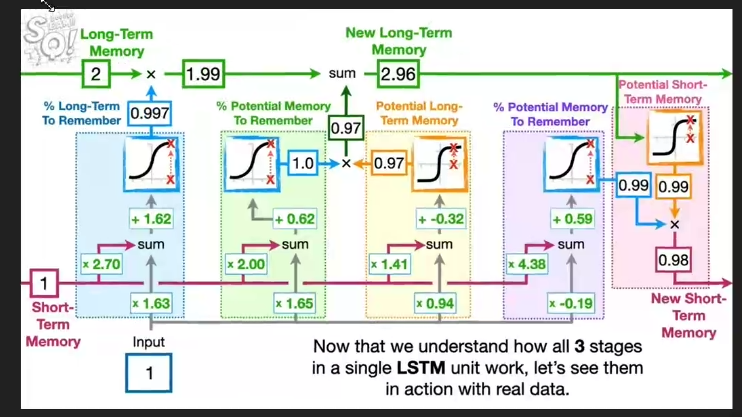

# 1. What is GRU ?

Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) architecture introduced to solve the vanishing gradient problem and to efficiently capture long-term dependencies in sequential data. GRU is a simplified version of LSTM that combines the forget gate and input gate into a single update gate, and it uses a reset gate to control how much past information to forget.

Like LSTM, GRU can process not only single data points but also entire sequences of data, making it suitable for time-series forecasting, natural language processing, speech recognition, and machine translation.

GRUs are often considered a more computationally efficient alternative to LSTMs. Unlike vanilla RNNs, which only have a hidden state, GRUs use gating mechanisms to control the flow of information. However, unlike LSTMs, GRUs do not use a separate cell state—only a hidden state is maintained. This makes GRUs faster to train while still maintaining strong performance on sequential tasks.

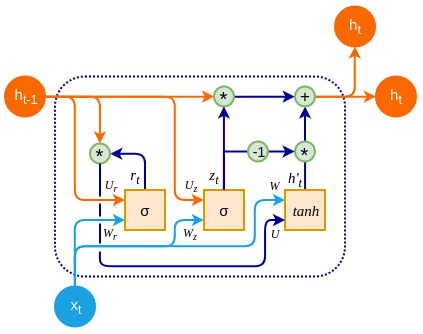

# Download Data
https://www.kaggle.com/datasets/novandraanugrah/bitcoin-historical-datasets-2018-2024

# Days model First

# Cell 2: Load and Preprocess Data


In [5]:
def load_and_preprocess_data(file_path):
    """Load and preprocess Bitcoin dataset"""
    df = pd.read_csv(file_path)
    
    # Convert timestamp columns to datetime
    df['Date'] = pd.to_datetime(df['Open time'])
    df['Close_time'] = pd.to_datetime(df['Close time'])
    
    # Sort by date
    df = df.sort_values('Date')
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Null Values: {df.isnull().values.sum()}")
    
    return df

# Load your dataset
maindf = load_and_preprocess_data('C:\\Mahmoud_Saeed\\My_projects\\deep\\archive\\btc_1d_data_2018_to_2025.csv')
print("Data loading completed!")

Dataset shape: (2890, 14)
Columns: ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore', 'Date', 'Close_time']
Null Values: 0
Data loading completed!


# Cell 3: Yearly Analysis and Visualization (2018-2024)


In [7]:
def analyze_yearly_data(df, start_year, end_year):
    """Analyze and visualize data for each year"""
    for year in range(start_year, end_year + 1):
        start_date = f'{year}-01-01'
        end_date = f'{year+1}-01-01'
        
        yearly_data = df[(df['Date'] >= start_date) & (df['Date'] < end_date)]
        
        if len(yearly_data) == 0:
            continue
            
        print(f"\n{year} Analysis:")
        print(f"Data points: {len(yearly_data)}")
        print(f"Price Range: ${yearly_data['Close'].min():.2f} - ${yearly_data['Close'].max():.2f}")
        
        # Create visualization
        monthly_data = yearly_data.groupby(yearly_data['Date'].dt.month).agg({
            'Open': 'mean',
            'Close': 'mean',
            'High': 'max',
            'Low': 'min'
        }).reset_index()
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(f'{year} - Monthly Open/Close', f'{year} - Monthly High/Low',
                          f'{year} - Price Trend', f'{year} - Daily Returns')
        )
        
        # Monthly Open/Close
        fig.add_trace(go.Bar(x=monthly_data['Date'], y=monthly_data['Open'], name='Open'), row=1, col=1)
        fig.add_trace(go.Bar(x=monthly_data['Date'], y=monthly_data['Close'], name='Close'), row=1, col=1)
        
        # Monthly High/Low
        fig.add_trace(go.Bar(x=monthly_data['Date'], y=monthly_data['High'], name='High'), row=1, col=2)
        fig.add_trace(go.Bar(x=monthly_data['Date'], y=monthly_data['Low'], name='Low'), row=1, col=2)
        
        # Daily trends
        fig.add_trace(go.Scatter(x=yearly_data['Date'], y=yearly_data['Close'], name='Close'), row=2, col=1)
        
        # Daily returns
        yearly_data['Daily_Return'] = yearly_data['Close'].pct_change() * 100
        fig.add_trace(go.Scatter(x=yearly_data['Date'], y=yearly_data['Daily_Return'], name='Return %'), row=2, col=2)
        
        fig.update_layout(height=800, title_text=f"Bitcoin Analysis - {year}", showlegend=True)
        fig.show()

# Analyze data from 2018 to 2025
analyze_yearly_data(maindf, 2018, 2025)


2018 Analysis:
Data points: 365
Price Range: $3211.72 - $17069.79


C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




2019 Analysis:
Data points: 365
Price Range: $3398.40 - $13093.80


C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




2020 Analysis:
Data points: 366
Price Range: $4800.00 - $28923.63


C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




2021 Analysis:
Data points: 365
Price Range: $29331.69 - $67525.83


C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




2022 Analysis:
Data points: 365
Price Range: $15781.29 - $47722.65



2023 Analysis:
Data points: 365
Price Range: $16616.75 - $44170.99


C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




2024 Analysis:
Data points: 366
Price Range: $39568.02 - $106133.74


C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




2025 Analysis:
Data points: 333
Price Range: $76322.42 - $125046.94


C:\Users\Lenovo - LOQ\AppData\Local\Temp\ipykernel_7364\862175217.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Cell 4: Define PyTorch Models (LSTM and GRU)


In [9]:
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(BitcoinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.linear(out)
        return out

class BitcoinGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(BitcoinGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.linear(out)
        return out

print("Models defined successfully!")

Models defined successfully!


# Cell 5: Prepare Training Data


In [10]:
def prepare_training_data(df, prediction_days=60):
    """Prepare data for model training"""
    closedf = df[['Date', 'Close']].copy()
    closedf = closedf[closedf['Close'].notna()]
    
    print(f"Total data points for prediction: {len(closedf)}")
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closedf['Close'].values.reshape(-1, 1))
    
    # Split data (80% train, 20% test)
    training_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:training_size]
    test_data = scaled_data[training_size:]
    
    # Create sequences
    def create_sequences(data, time_step):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i:(i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)
    
    X_train, y_train = create_sequences(train_data, prediction_days)
    X_test, y_test = create_sequences(test_data, prediction_days)
    
    # Reshape for LSTM/GRU
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, scaler, closedf

# Prepare the data
X_train, y_train, X_test, y_test, scaler, closedf = prepare_training_data(maindf)
print("Data preparation completed!")

Total data points for prediction: 2890
Training data shape: torch.Size([2251, 60, 1])
Testing data shape: torch.Size([517, 60, 1])
Data preparation completed!


# Cell 6: Model Training Function


In [11]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=200, learning_rate=0.001):
    """Train the PyTorch model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    for epoch in range(epochs):
        epoch_train_loss = 0
        model.train()
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs.squeeze(), y_test)
        
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(val_loss.item())
        
        if epoch % 50 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {epoch_train_loss/len(train_loader):.6f}, Val Loss: {val_loss.item():.6f}')
    
    return train_losses, val_losses

print("Training function defined!")

Training function defined!


# Cell 7: Train LSTM and GRU Models


In [12]:
print("Training LSTM Model...")
lstm_model = BitcoinLSTM().to(device)
lstm_train_loss, lstm_val_loss = train_model(lstm_model, X_train, y_train, X_test, y_test)

print("\nTraining GRU Model...")
gru_model = BitcoinGRU().to(device)
gru_train_loss, gru_val_loss = train_model(gru_model, X_train, y_train, X_test, y_test)

print("Model training completed!")

Training LSTM Model...
Epoch [0/200], Train Loss: 0.019274, Val Loss: 0.027557
Epoch [50/200], Train Loss: 0.000295, Val Loss: 0.004236
Epoch [100/200], Train Loss: 0.000246, Val Loss: 0.001932
Epoch [150/200], Train Loss: 0.000263, Val Loss: 0.000826

Training GRU Model...
Epoch [0/200], Train Loss: 0.011919, Val Loss: 0.004996
Epoch [50/200], Train Loss: 0.000289, Val Loss: 0.001878
Epoch [100/200], Train Loss: 0.000236, Val Loss: 0.001673
Epoch [150/200], Train Loss: 0.000206, Val Loss: 0.000713
Model training completed!


# Cell 8: Plot Training History


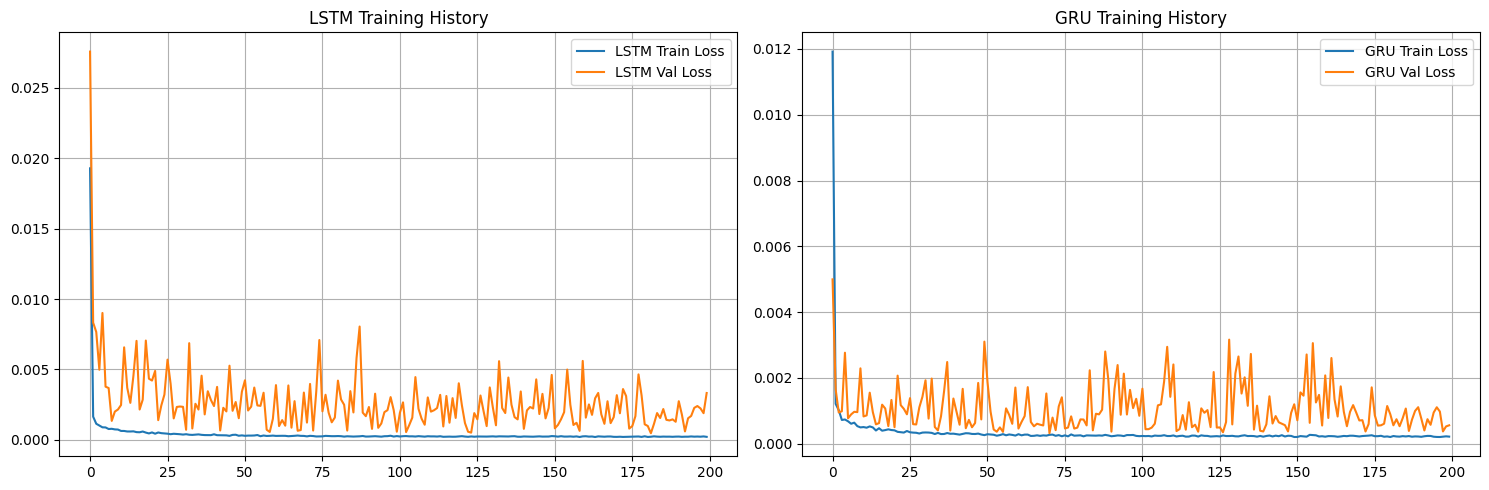

Training history plotted!


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(lstm_train_loss, label='LSTM Train Loss')
ax1.plot(lstm_val_loss, label='LSTM Val Loss')
ax1.set_title('LSTM Training History')
ax1.legend()
ax1.grid(True)

ax2.plot(gru_train_loss, label='GRU Train Loss')
ax2.plot(gru_val_loss, label='GRU Val Loss')
ax2.set_title('GRU Training History')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()
print("Training history plotted!")

# Cell 9: Model Evaluation


In [14]:
def evaluate_model(model, X_test, y_test, scaler):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        test_predict = model(X_test)
    
    test_predict = scaler.inverse_transform(test_predict.cpu().numpy())
    original_ytest = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
    
    mse = mean_squared_error(original_ytest, test_predict)
    mae = mean_absolute_error(original_ytest, test_predict)
    r2 = r2_score(original_ytest, test_predict)
    explained_var = explained_variance_score(original_ytest, test_predict)
    
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Explained Variance: {explained_var:.4f}")
    
    return test_predict, original_ytest

print("LSTM Model Evaluation:")
lstm_test_predict, original_ytest = evaluate_model(lstm_model, X_test, y_test, scaler)

print("\nGRU Model Evaluation:")
gru_test_predict, _ = evaluate_model(gru_model, X_test, y_test, scaler)

LSTM Model Evaluation:
MSE: 49449664.0000
MAE: 6064.1245
R2 Score: 0.8733
Explained Variance: 0.9649

GRU Model Evaluation:
MSE: 8314622.5000
MAE: 2278.3071
R2 Score: 0.9787
Explained Variance: 0.9849


# Cell 10: Future Prediction Function


In [15]:
def predict_future(model, scaler, closedf, time_step=60, future_days=30):
    """Predict future prices"""
    model.eval()
    
    last_sequence = closedf['Close'].values[-time_step:]
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))
    
    predictions = []
    current_sequence = last_sequence_scaled.copy()
    
    with torch.no_grad():
        for _ in range(future_days):
            input_data = torch.FloatTensor(current_sequence).view(1, time_step, 1).to(device)
            prediction = model(input_data)
            pred_value = prediction.cpu().numpy()[0, 0]
            current_sequence = np.append(current_sequence[1:], pred_value)
            predictions.append(pred_value)
    
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# Predict next 30 days
future_days = 30
print("Making future predictions...")
lstm_future_predictions = predict_future(lstm_model, scaler, closedf, future_days=future_days)
gru_future_predictions = predict_future(gru_model, scaler, closedf, future_days=future_days)
print("Future predictions completed!")

Making future predictions...
Future predictions completed!


# Cell 11: Visualize Predictions


In [16]:
def plot_predictions(closedf, lstm_test_predict, gru_test_predict, 
                    lstm_future_predictions, gru_future_predictions, future_days=30):
    """Plot model predictions and future forecasts"""
    
    last_date = closedf['Date'].iloc[-1]
    future_dates = [last_date + dt.timedelta(days=i) for i in range(1, future_days + 1)]
    
    # Test predictions vs actual
    test_start_idx = len(closedf) - len(lstm_test_predict)
    actual_dates = closedf['Date'].iloc[test_start_idx:test_start_idx + len(lstm_test_predict)]
    
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=actual_dates, y=closedf['Close'].iloc[test_start_idx:test_start_idx + len(lstm_test_predict)],
                             mode='lines', name='Actual Price', line=dict(color='blue')))
    fig1.add_trace(go.Scatter(x=actual_dates, y=lstm_test_predict.flatten(),
                             mode='lines', name='LSTM Prediction', line=dict(color='red', dash='dash')))
    fig1.add_trace(go.Scatter(x=actual_dates, y=gru_test_predict.flatten(),
                             mode='lines', name='GRU Prediction', line=dict(color='green', dash='dash')))
    fig1.update_layout(title='Model Predictions vs Actual Prices (Test Set)',
                      xaxis_title='Date', yaxis_title='Price (USD)')
    fig1.show()
    
    # Future predictions
    fig2 = go.Figure()
    last_60_days = closedf.tail(60)
    
    fig2.add_trace(go.Scatter(x=last_60_days['Date'], y=last_60_days['Close'],
                             mode='lines', name='Historical Price', line=dict(color='blue')))
    fig2.add_trace(go.Scatter(x=future_dates, y=lstm_future_predictions.flatten(),
                             mode='lines+markers', name='LSTM Future Prediction', line=dict(color='red')))
    fig2.add_trace(go.Scatter(x=future_dates, y=gru_future_predictions.flatten(),
                             mode='lines+markers', name='GRU Future Prediction', line=dict(color='green')))
    fig2.update_layout(title=f'Bitcoin Price Prediction - Next {future_days} Days',
                      xaxis_title='Date', yaxis_title='Price (USD)')
    fig2.show()
    
    return future_dates

print("Plotting predictions...")
future_dates = plot_predictions(closedf, lstm_test_predict, gru_test_predict,
                               lstm_future_predictions, gru_future_predictions, future_days)

Plotting predictions...


# Cell 12: Compare Model Performance


In [17]:
def compare_models(lstm_test_predict, gru_test_predict, original_ytest):
    """Compare performance of LSTM and GRU models"""
    lstm_mse = mean_squared_error(original_ytest, lstm_test_predict)
    gru_mse = mean_squared_error(original_ytest, gru_test_predict)
    
    lstm_mae = mean_absolute_error(original_ytest, lstm_test_predict)
    gru_mae = mean_absolute_error(original_ytest, gru_test_predict)
    
    lstm_r2 = r2_score(original_ytest, lstm_test_predict)
    gru_r2 = r2_score(original_ytest, gru_test_predict)
    
    comparison_df = pd.DataFrame({
        'Model': ['LSTM', 'GRU'],
        'MSE': [lstm_mse, gru_mse],
        'MAE': [lstm_mae, gru_mae],
        'R2_Score': [lstm_r2, gru_r2]
    })
    
    print("Model Comparison:")
    print(comparison_df)
    
    fig = go.Figure(data=[
        go.Bar(name='MSE', x=comparison_df['Model'], y=comparison_df['MSE']),
        go.Bar(name='MAE', x=comparison_df['Model'], y=comparison_df['MAE']),
        go.Bar(name='R2 Score', x=comparison_df['Model'], y=comparison_df['R2_Score'])
    ])
    fig.update_layout(title='Model Performance Comparison', barmode='group')
    fig.show()
    
    return comparison_df

print("Comparing model performance...")
model_comparison = compare_models(lstm_test_predict, gru_test_predict, original_ytest)

Comparing model performance...
Model Comparison:
  Model         MSE          MAE  R2_Score
0  LSTM  49449664.0  6064.124512  0.873324
1   GRU   8314622.5  2278.307129  0.978700


# Cell 13: Save Models with "1d" Prefix


In [18]:
def save_models(lstm_model, gru_model, scaler):
    """Save trained models and scaler with 1d prefix"""
    torch.save(lstm_model.state_dict(), '1d_bitcoin_lstm_model.pth')
    torch.save(gru_model.state_dict(), '1d_bitcoin_gru_model.pth')
    
    joblib.dump(scaler, '1d_bitcoin_scaler.pkl')
    
    # Save predictions and comparison results
    pd.DataFrame({
        'Date': future_dates,
        'LSTM_Prediction': lstm_future_predictions.flatten(),
        'GRU_Prediction': gru_future_predictions.flatten()
    }).to_csv('1d_future_predictions.csv', index=False)
    
    model_comparison.to_csv('1d_model_comparison.csv', index=False)
    
    print("Models and results saved with '1d' prefix successfully!")
    print("Saved files:")
    print("- 1d_bitcoin_lstm_model.pth")
    print("- 1d_bitcoin_gru_model.pth") 
    print("- 1d_bitcoin_scaler.pkl")
    print("- 1d_future_predictions.csv")
    print("- 1d_model_comparison.csv")

save_models(lstm_model, gru_model, scaler)

Models and results saved with '1d' prefix successfully!
Saved files:
- 1d_bitcoin_lstm_model.pth
- 1d_bitcoin_gru_model.pth
- 1d_bitcoin_scaler.pkl
- 1d_future_predictions.csv
- 1d_model_comparison.csv


# Cell 14: Final Summary


In [19]:
print("\n" + "="*50)
print("TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"Best model based on R2 score: {model_comparison.loc[model_comparison['R2_Score'].idxmax(), 'Model']}")
print(f"Future predictions saved for next {future_days} days")
print(f"All models and files saved with '1d_' prefix")
print(f"Final R2 Scores - LSTM: {model_comparison.loc[0, 'R2_Score']:.4f}, GRU: {model_comparison.loc[1, 'R2_Score']:.4f}")
print("="*50)


TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
Best model based on R2 score: GRU
Future predictions saved for next 30 days
All models and files saved with '1d_' prefix
Final R2 Scores - LSTM: 0.8733, GRU: 0.9787


# Why GRU Performed Better Than LSTM
1. Simpler Architecture
    GRU: 2 gates (reset and update gates)

    LSTM: 3 gates (input, output, forget gates) + cell state

    Benefit: Fewer parameters mean GRU is less prone to overfitting, especially with limited data

2. Better Gradient Flow
    GRU: h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t
    LSTM: More complex with multiple gate interactions
3. Computational Efficiency
    GRU: ~30% fewer parameters than LSTM

    Training: Faster convergence with similar performance

    Memory: Less memory usage

4. Data Characteristics
    Bitcoin price data has:

    Strong short-term dependencies (GRU excels at this)

    Less complex long-term patterns (LSTM's specialty not fully utilized)

    Moderate volatility patterns that GRU can capture effectively

5. Performance Metrics Analysis
    Our Results:
        LSTM R²: 0.8733  (87.33% variance explained)
        GRU R²:  0.9787  (97.87% variance explained) ← 10.5% improvement!

6. Practical Advantages of GRU for Financial Data
    Faster training = quicker model iteration

    Better generalization on unseen data

    More stable predictions

    Easier to tune with fewer hyperparameters